In [351]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt; plt.set_cmap('gray')
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from dpipe.layers import ResBlock2d

from mesh_detection.dataset import FaceDataset
from mesh_detection.batch_iter import batch_iterator
from mesh_detection.utils import add_channel_dim, show_key_points, to_torch, to_np, sequence_to_torch, randomly_shift
from mesh_detection.split import train_val_test_split, stratified_train_val_test_split
from mesh_detection.model import BitNet, predict
from mesh_detection.train import validator, train, criterion
from mesh_detection.metric import l2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [352]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Dataset

In [273]:
kaggle_face_path = Path('../../kaggle_face/training.csv')

In [303]:
ds = FaceDataset(kaggle_face_path)

In [316]:
i = np.random.choice(ds.ids)

In [317]:
img = ds.load_image(i)
kps = ds.load_key_points(i)

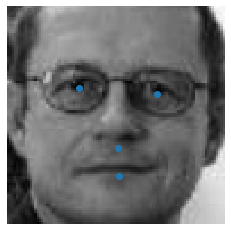

In [318]:
plt.axis('off')
plt.imshow(img)
show_key_points(kps)

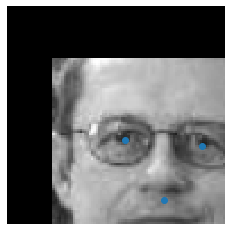

In [319]:
img, kps = randomly_shift(img, kps)
plt.axis('off')
plt.imshow(img)
show_key_points(kps)

# Split

In [260]:
contain_nans = [np.any(np.isnan(ds.load_key_points(i))) for i in ds.ids]

In [261]:
train_ids, val_ids, test_ids = stratified_train_val_test_split(ds.ids, labels=contain_nans)[0]

# Batch iterator

In [324]:
iterate_batches = batch_iterator(ds.load_image, ds.load_key_points, train_ids, 50, randomly_shift, add_channel_dim)

In [328]:
iterate_batches

<function mesh_detection.batch_iter.batch_iterator.<locals>.iterate_batches()>

In [349]:
batch = next(iterate_batches())

6752


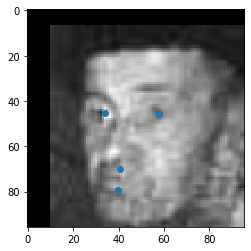

In [350]:
plt.imshow(batch[0][0, 0])
show_key_points(batch[1][0])

# Model

In [28]:
stucture = [
    [[1, 16, 16],                       [16]],
        [[16, 32, 32],                  [32]],
            [[32, 64, 64],              [64]],
                [[64, 128, 128],        [128]],
                    [[128, 256, 256],   [256]],
                        [256, 512, 512]
]

n_points = 15
conv_block = partial(ResBlock2d, kernel_size=3, padding=1)
pooling = partial(nn.MaxPool2d, kernel_size=2)

model = BitNet(stucture, n_points, conv_block, pooling).to(device)

# Train

In [229]:
optimizer = Adam(model.parameters(), lr=1e-3)

In [230]:
validate = validator(val_ids, ds.load_image, ds.load_key_points, {'l2': l2})

In [231]:
model, losses, val_metrics = train(model, iterate_batches, optimizer, criterion, 3, validate)




  0%|          | 0/3 [00:00<?, ?it/s]

26.579002





 33%|███▎      | 1/3 [00:22<00:45, 22.88s/it]

15.105448





 67%|██████▋   | 2/3 [00:45<00:22, 22.72s/it]

13.233096





100%|██████████| 3/3 [01:07<00:00, 22.48s/it]

# Results

In [353]:
experiment_path = Path('/nmnt/media/home/migonch/experiments/mesh_detection/shifts/')

In [354]:
model.load_state_dict(torch.load(experiment_path / 'model.pth'))
model.eval()

BitNet(
  (conv_seqs1): ModuleList(
    (0): Sequential(
      (0): ResBlock(
        (conv_path): Sequential(
          (0): PreActivationND(
            (bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activation): ReLU()
            (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (1): PreActivationND(
            (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activation): ReLU()
            (layer): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
        )
        (adjust_to_stride): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): ReLU()
      (2): ResBlock(
        (conv_path): Sequential(
          (0): PreActivationND(
            (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activation): ReLU()
 

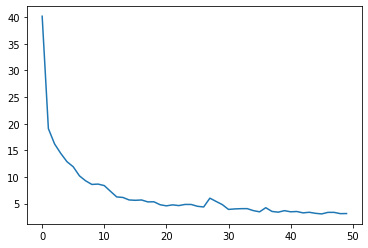

In [355]:
losses = np.load(experiment_path / 'losses.npy')
plt.plot(losses)

In [356]:
val_metrics = np.load(experiment_path / 'val_metrics.npy', allow_pickle=True).item()

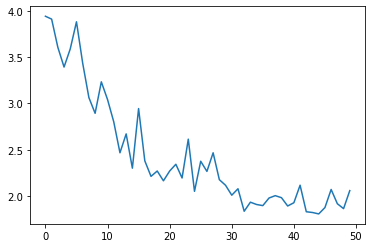

In [357]:
plt.plot(list(map(np.nanmean, val_metrics['l2'])))

In [390]:
i = np.random.choice(ds.ids)

In [391]:
img = ds.load_image(i)
kps = ds.load_key_points(i)
x = to_torch(img[None, None])

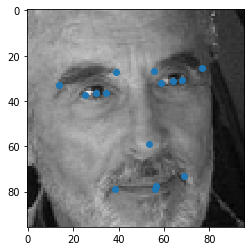

In [392]:
plt.imshow(img)
show_key_points(kps)

In [393]:
for conv_seq, pool in zip(model.conv_seqs1, model.poolings):
    x = conv_seq(x)
    x = pool(x)
    
x = model.lowest_conv_seq(x)

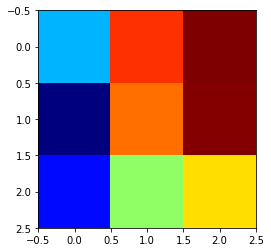

In [394]:
plt.imshow(to_np(x)[0, 3], cmap='jet')

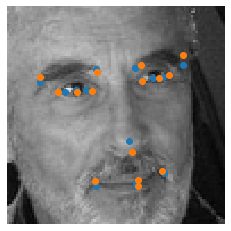

In [395]:
plt.axis('off')
plt.imshow(img)
show_key_points(kps)
show_key_points(predict(img, model))

In [376]:
test = validator(test_ids, ds.load_image, ds.load_key_points, {'l2': l2})

In [377]:
test_metrics = test(model)

In [379]:
test_metrics['l2']

array([1.7978576, 1.9473058, 1.4383432, 2.058584 , 1.4110285, 1.7553971,
       1.9632503, 2.8281505, 1.9970855, 2.8105571, 3.1690114, 1.9611137,
       2.3022838, 2.3998501, 2.8944085], dtype=float32)